# Study: Dynamic bistable hidden Markov model

## A case study comparing Bean Machine-based MCMC inference with Rejection ABC

In this notebook, we will walk through performing inference for a Bistable Hidden Markov Model (HMM) with Bean Machine MCMC and compare it with handwritten Approximate Bayesian Computation (ABC) Inference.

This Study assumes you're already relatively familiar with Bean Machine. If this is your first exposure, consider checking out one of the Tutorials, which introduce fundamental Bean Machine concepts.

This Study builds upon the Bistable HMM model referred to in [Approximate Bayesian Computation](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803). The Bistable HMM model is used in several biological and non-equilibirium themodynamic systems. An intutive visual example is bistable perception, where our visual perception of an ambgious 2D image cycles between two stable configurations in 3D. Can you make out the two percepts in this image?

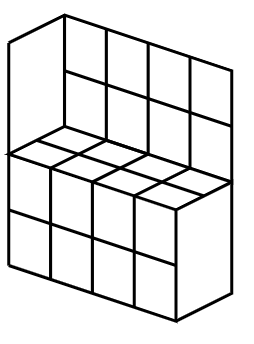

For this problem setup, in addition to viewing the image in a particular way, we also consider that there's a noisiness to measuring that perception. We'd like to model the entire system, which includes both the state that our perception is in, as well as our measurement of the perception.

## Prerequisites

Let's model this in Bean Machine! Import the Bean Machine library and some fundamental PyTorch classes.

In [424]:
import beanmachine.ppl as bm

import torch
from torch import tensor
import torch.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rc('axes', xmargin=0, ymargin=0)
plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('hist', bins=30)
plt.rc('lines', linewidth=2.5)

pd.set_option('precision', 3)

torch.manual_seed(12);

## Model definition

We can imagine your perception cycling between two states, $A$ and $B$, in a biological dynamical model. If the probability of to transition from one state to the other at a time step is defined as $\theta$ in both directions, the probability to remain in the same state at each time step is $1 - \theta$. The probability to measure the state correctly is $\gamma$, and the probability to measure incorrectly is $1 - \gamma$.

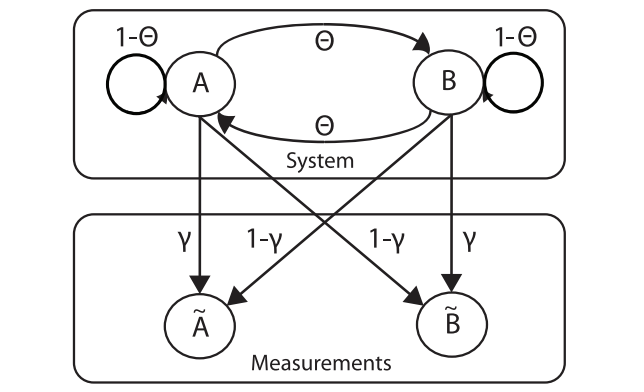

Let the hidden **s**tate and **m**easured state of the system at time $t$ be denoted by $S(t)$ and $M(t)$ respectively. 

Conditional on the true, unobserved state at time $t$, denoted $S(t)$, other probabilistic properties of the system are known:

| $S(t)$ | $\mathbb{P}(S(t+1) = A)$ | $\mathbb{P}(S(t+1) = B)$ | $\mathbb{P}(M(t) = A)$ | $\mathbb{P}(M(t) = B)$ |
| --- | --- | --- | --- | --- |
| $A$<img width=50/> | $1 - \theta$<img width=140/> | $\theta$<img width=140/> | $\gamma$<img width=110/> | $1 - \gamma$<img width=110/> |
| $B$ | $\theta$ | $1 - \theta$ | $1 - \gamma$ | $\gamma$ |

The symmetric properties of this two-state HMM is where the bistable HMM gets its name from.

To fully define the Bayesian model, we'll need to pin down a few priors. We use these assumptions:

* $\theta \sim \text{Uniform}(0, 1)$. This uninformative prior introduces no additional knowledge about the state transition probability.
* $\gamma \sim \text{Beta}(5, 0.75)$. On the other hand, this informative prior for measurement accuracy reflects a prior belief that less than 1 out of every 6 measurements is incorrect.

Let's take a moment to visualize the priors.

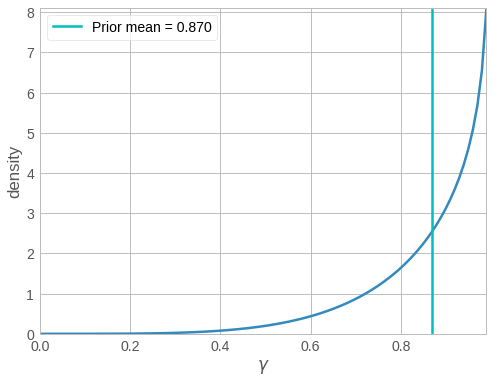

In [425]:
gamma_prior = dist.Beta(5., 0.75)
gammas = torch.linspace(0, 1, 100)
plt.plot(gammas, gamma_prior.log_prob(gammas).exp())
plt.axvline(gamma_prior.mean, label=f"Prior mean = {gamma_prior.mean :.3f}", color="c")
plt.xlabel("$\gamma$")
plt.ylabel("density")
plt.legend();

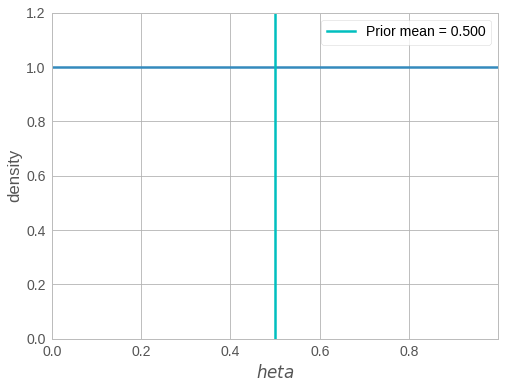

In [426]:
theta_prior = dist.Uniform(0., 1.)
thetas = torch.linspace(0, 1, 1000)[:-1]
plt.plot(thetas, theta_prior.log_prob(thetas).exp())
plt.axvline(theta_prior.mean, label=f"Prior mean = {theta_prior.mean :.3f}", color="c")
plt.xlabel("$\theta$")
plt.ylabel("density")
plt.ylim(0, 1.2)
plt.legend();

Below we build the model using PyTorch distributions.

In [427]:
@bm.random_variable
def theta():
    return dist.Uniform(0, 1)

@bm.random_variable
def gamma():
    return dist.Beta(5, 0.75)

@bm.random_variable
def S(i):
    if i == 0:
        return dist.Bernoulli(0.)
    else:
        return dist.Bernoulli(
            theta() * (1. - S(i - 1)) +
            (1. - theta()) * S(i - 1)
        )
    
@bm.random_variable
def M(i):
    return dist.Bernoulli(
        gamma() * S(i) +
        (1 - gamma()) * (1 - S(i))
    )

## Data

With the model built, let's simulate a dataset with known ground truth values. For ease, we denote state $A$ with $0$ and state $B$ with $1$. Values for $\theta$ and $\gamma$ are typical and obtained from the referred work. $N$ is the number of time steps.

In [428]:
N = 100
true_theta = 0.25
true_gamma = 0.98

We can use this inference trick to generate a dataset from known ground-truth values for latent random variables.

In [429]:
ground_truth_samples = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=(
        [ theta(), gamma() ] +
        [ S(i) for i in range(N) ] +
        [ M(i) for i in range(N) ]
    ),
    observations={
        theta(): tensor(true_theta),
        gamma(): tensor(true_gamma),
    },
    num_samples=1,
    num_chains=1,
    initialize_from_prior=True,
)

true_S = tensor([ground_truth_samples[ S(i) ].item() for i in range(N)])
true_M = tensor([ground_truth_samples[ M(i) ].item() for i in range(N)])

Samples collected: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Great! Let's validate that a few statistics of the generated data look roughly like what we expected.

In [430]:
print(
    f"True theta:\t\t{true_theta}\n"
    f"Empirical theta:\t{true_S[1:].ne(true_S[:-1]).float().mean() :.3f}\n"
    f"True gamma:\t\t{true_gamma}\n"
    f"Empricial gamma:\t{true_S.eq(true_M).float().mean() :.3f}"
)

True theta:		0.25
Empirical theta:	0.293
True gamma:		0.98
Empricial gamma:	0.980


## Inference

Our model makes use of both continuous and discrete random variables. We'll want to make use of different inference strategies for each. In particular, we would like to take advantage of gradient information for the continuous random variables. To facilitate this, Bean Machine provides the `CompositionalInference` class.

`CompositionalInference` is a powerful, flexible class for configuring inference in a variety of ways. By default, `CompositionalInference` will select an inference method for each random variable that is appropriate based on its support. The HMM presented in this tutorial has a number of different random variables that we're interested in learning about. Those random variables, along with their supports and the inference method that `CompositionalInference` will automatically select for them, are summarized in the table below:

| Random variable | Support | Inference method | Transform?
| --- | --- | --- | ---
| $\theta$ | $[0, 1]$ | Newtonian Monte Carlo | Yes (to unconstrained)
| $\gamma$ | $[0, 1]$ | Newtonian Monte Carlo | Yes (to unconstrained)
| $S(i)$ | $0, 1$ | Uniform sampler | No (unnecessary)

You can learn more about compositional inference in our framework topics.

Normally, this is all you would have to do! However, the HMM model has meaningful structure that we would like to consider when configuring our inference strategy. In particular, the hidden state of each time step is highly correlated with the observable emissions of that state. Thus, if our inference proposes a new value for $S(t)$, we would also like to jointly propose new values for $\gamma$. In order to update these variables jointly (as opposed to by single-site), we can make use of block inference.

We configure block inference using the method `add_sequential_proposer`, which takes a list of variables as an argument. Note that, unlike in typical Bean Machine syntax, we don't include arguments to variable objects when defining the block inference scheme. This is because the framework can compute the minimal _specific_ set of variables to update from the random variable families provided to this function. The next paragraph explains how that block selection is performed, and is quite technical! Feel free to skip it if desired.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Block inference selects specific subsets of random variables to update jointly. This is based upon which variables would typically be included in one another's Markov blanket during a single-site update. The Markov blanket of a random variable is a statistical concept defining which  other random variables may be directly affected when we propose a new value for the current random variable. It includes the current random variable's parents, children, and parents-of-children. To be concrete, consider our example where we block together <code>S</code>, and <code>gamma</code>. Our single-site inference typically runs inference for each individual <code>S(i)</code> and for <code>gamma()</code>, doing separate accept-reject procedures for each individual node of the probabilistic model. With block inference, before computing the accept-reject probability on some <code>S(i)</code> (for a specific <code>i</code>), the method will search the Markov blanket of <code>S(i)</code> to find all variables that would be directly affected by an update to <code>S(i)</code>. Any variables of the form <code>S(i)</code> (for any <code>i</code>) or <code>gamma()</code> will be blocked together, since that's what we configured with <code>add_sequential_proposer</code>. New proposals for <i>all</i> of these variables will be jointly accepted or rejected together. Read more about block inference in our documentation.
</div>

In [431]:
inference_strategy = bm.CompositionalInference()

inference_strategy.add_sequential_proposer([ S, gamma ])

samples = inference_strategy.infer(
    queries=[ theta(), gamma() ],
    observations={ M(i): true_M[i] for i in range(N) },
    num_samples=1000,
    num_chains=1,
)

Samples collected: 100%|██████████| 1000/1000 [1:03:04<00:00,  3.78s/it]


## Analysis

`samples` now contains our inference results.

In [432]:
theta_marginal = samples[ theta() ].flatten(start_dim=0, end_dim=1).detach()
gamma_marginal = samples[ gamma() ].flatten(start_dim=0, end_dim=1).detach()

print(
    f"theta_marginal: {theta_marginal[:8]} ...\n"
    f"gamma_marginal: {gamma_marginal[:8]} ...\n"
)

theta_marginal: tensor([0.3240, 0.3240, 0.3240, 0.3240, 0.3240, 0.3240, 0.3240, 0.3240]) ...
gamma_marginal: tensor([0.5308, 0.4571, 0.4879, 0.6389, 0.7436, 0.7621, 0.6733, 0.8031]) ...



Let's plot our inferred marginals and look at the diagnostics.

In [433]:
def plot_marginal(
    marginal_0_name,
    marginal_0,
    marginal_0_true_value=None,
    marginal_1_name=None,
    marginal_1=None,
    marginal_1_true_value=None,
):
    marginal_0 = marginal_0.squeeze()
    if len(marginal_0.shape) != 1:
        raise ValueError(
            f"Expected: marginal_0 has shape [:].\n"
            f"Actual: marginal_0 has shape {marginal_0.shape}."
        )
    
    if marginal_1 is None:
        plt.title(f"{marginal_0_name} marginal")
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(x=marginal_0_true_value, label="True value", color="k")
        plt.axvline(x=marginal_0.mean(), label="Posterior mean", color="c")
        plt.xlabel(marginal_0_name)
        plt.ylabel("density")
        plt.legend()
        
    else:
        marginal_1 = marginal_1.squeeze()
        if len(marginal_1.shape) != 1:
            raise ValueError(
                f"Expected: marginal_1 has shape [:].\n"
                f"Actual: marginal_1 has shape {marginal_1.shape}."
            )
        
        plt.suptitle(f"Joint distribution of {marginal_0_name} and {marginal_1_name}", fontsize=20)
        
        grid = mpl.gridspec.GridSpec(4, 4)

        plt.subplot(grid[1:, :3])
        plt.hist2d(marginal_0.tolist(), marginal_1.tolist(), bins=60, density=True)
        if marginal_0_true_value is not None and marginal_1_true_value is not None:
            plt.plot(marginal_0_true_value, marginal_1_true_value, "wo", label="True value")
        plt.plot(marginal_0.mean(), marginal_1.mean(), "co", label="Posterior marginal mean")
        plt.xlabel(f"{marginal_0_name}")
        plt.ylabel(f"{marginal_1_name}")
        plt.legend()

        plt.subplot(grid[0, :3])
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(marginal_0_true_value, color="k")
        plt.axvline(marginal_0.mean(), color="c")
        plt.ylabel("density")
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.margins(0)

        plt.subplot(grid[1:, 3])
        plt.hist(marginal_1, density=True, orientation="horizontal")
        if marginal_1_true_value is not None:
            plt.axhline(marginal_1_true_value, color="k")
        plt.axhline(marginal_1.mean(), color="c")
        plt.xlabel("density")
        plt.gca().axes.get_yaxis().set_ticklabels([])
        plt.margins(0)

    plt.show()

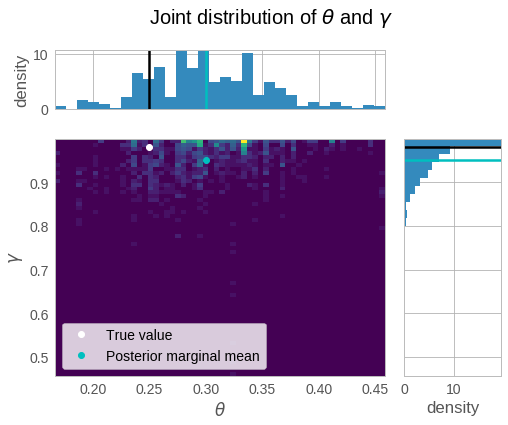

In [434]:
plot_marginal(r"$\theta$", theta_marginal, true_theta, r"$\gamma$", gamma_marginal, true_gamma)

And look at the diagnostics.

In [435]:
bm.Diagnostics(samples).summary()

,avg,std,2.5%,50%,97.5%,n_eff
gamma()[],0.952,0.052,0.830,0.968,0.999,92.960
theta()[],0.300,0.052,0.201,0.295,0.410,71.804


In [436]:
bm.Diagnostics(samples).plot(display=True);

Overall, the inference looks healthy, and produced correct results. However, it took a very long time to run! Can we do better?

## Approximate Bayesian Computation on the bistable HMM

To address the runtime issues of fully-Bayesian inference, let's consider an inference approach called [Approximate Bayesian Computation](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803) (ABC).

You can read more about ABC in the linked paper. For an overview, ABC focuses on generating samples from priors and then simulating data from those samples. These data are then compared with observed data; the parameters which generated data close to observations are accepted and combined to obtain an approximate posterior. This figure from the paper does a nice job of summarizing the algorithm:

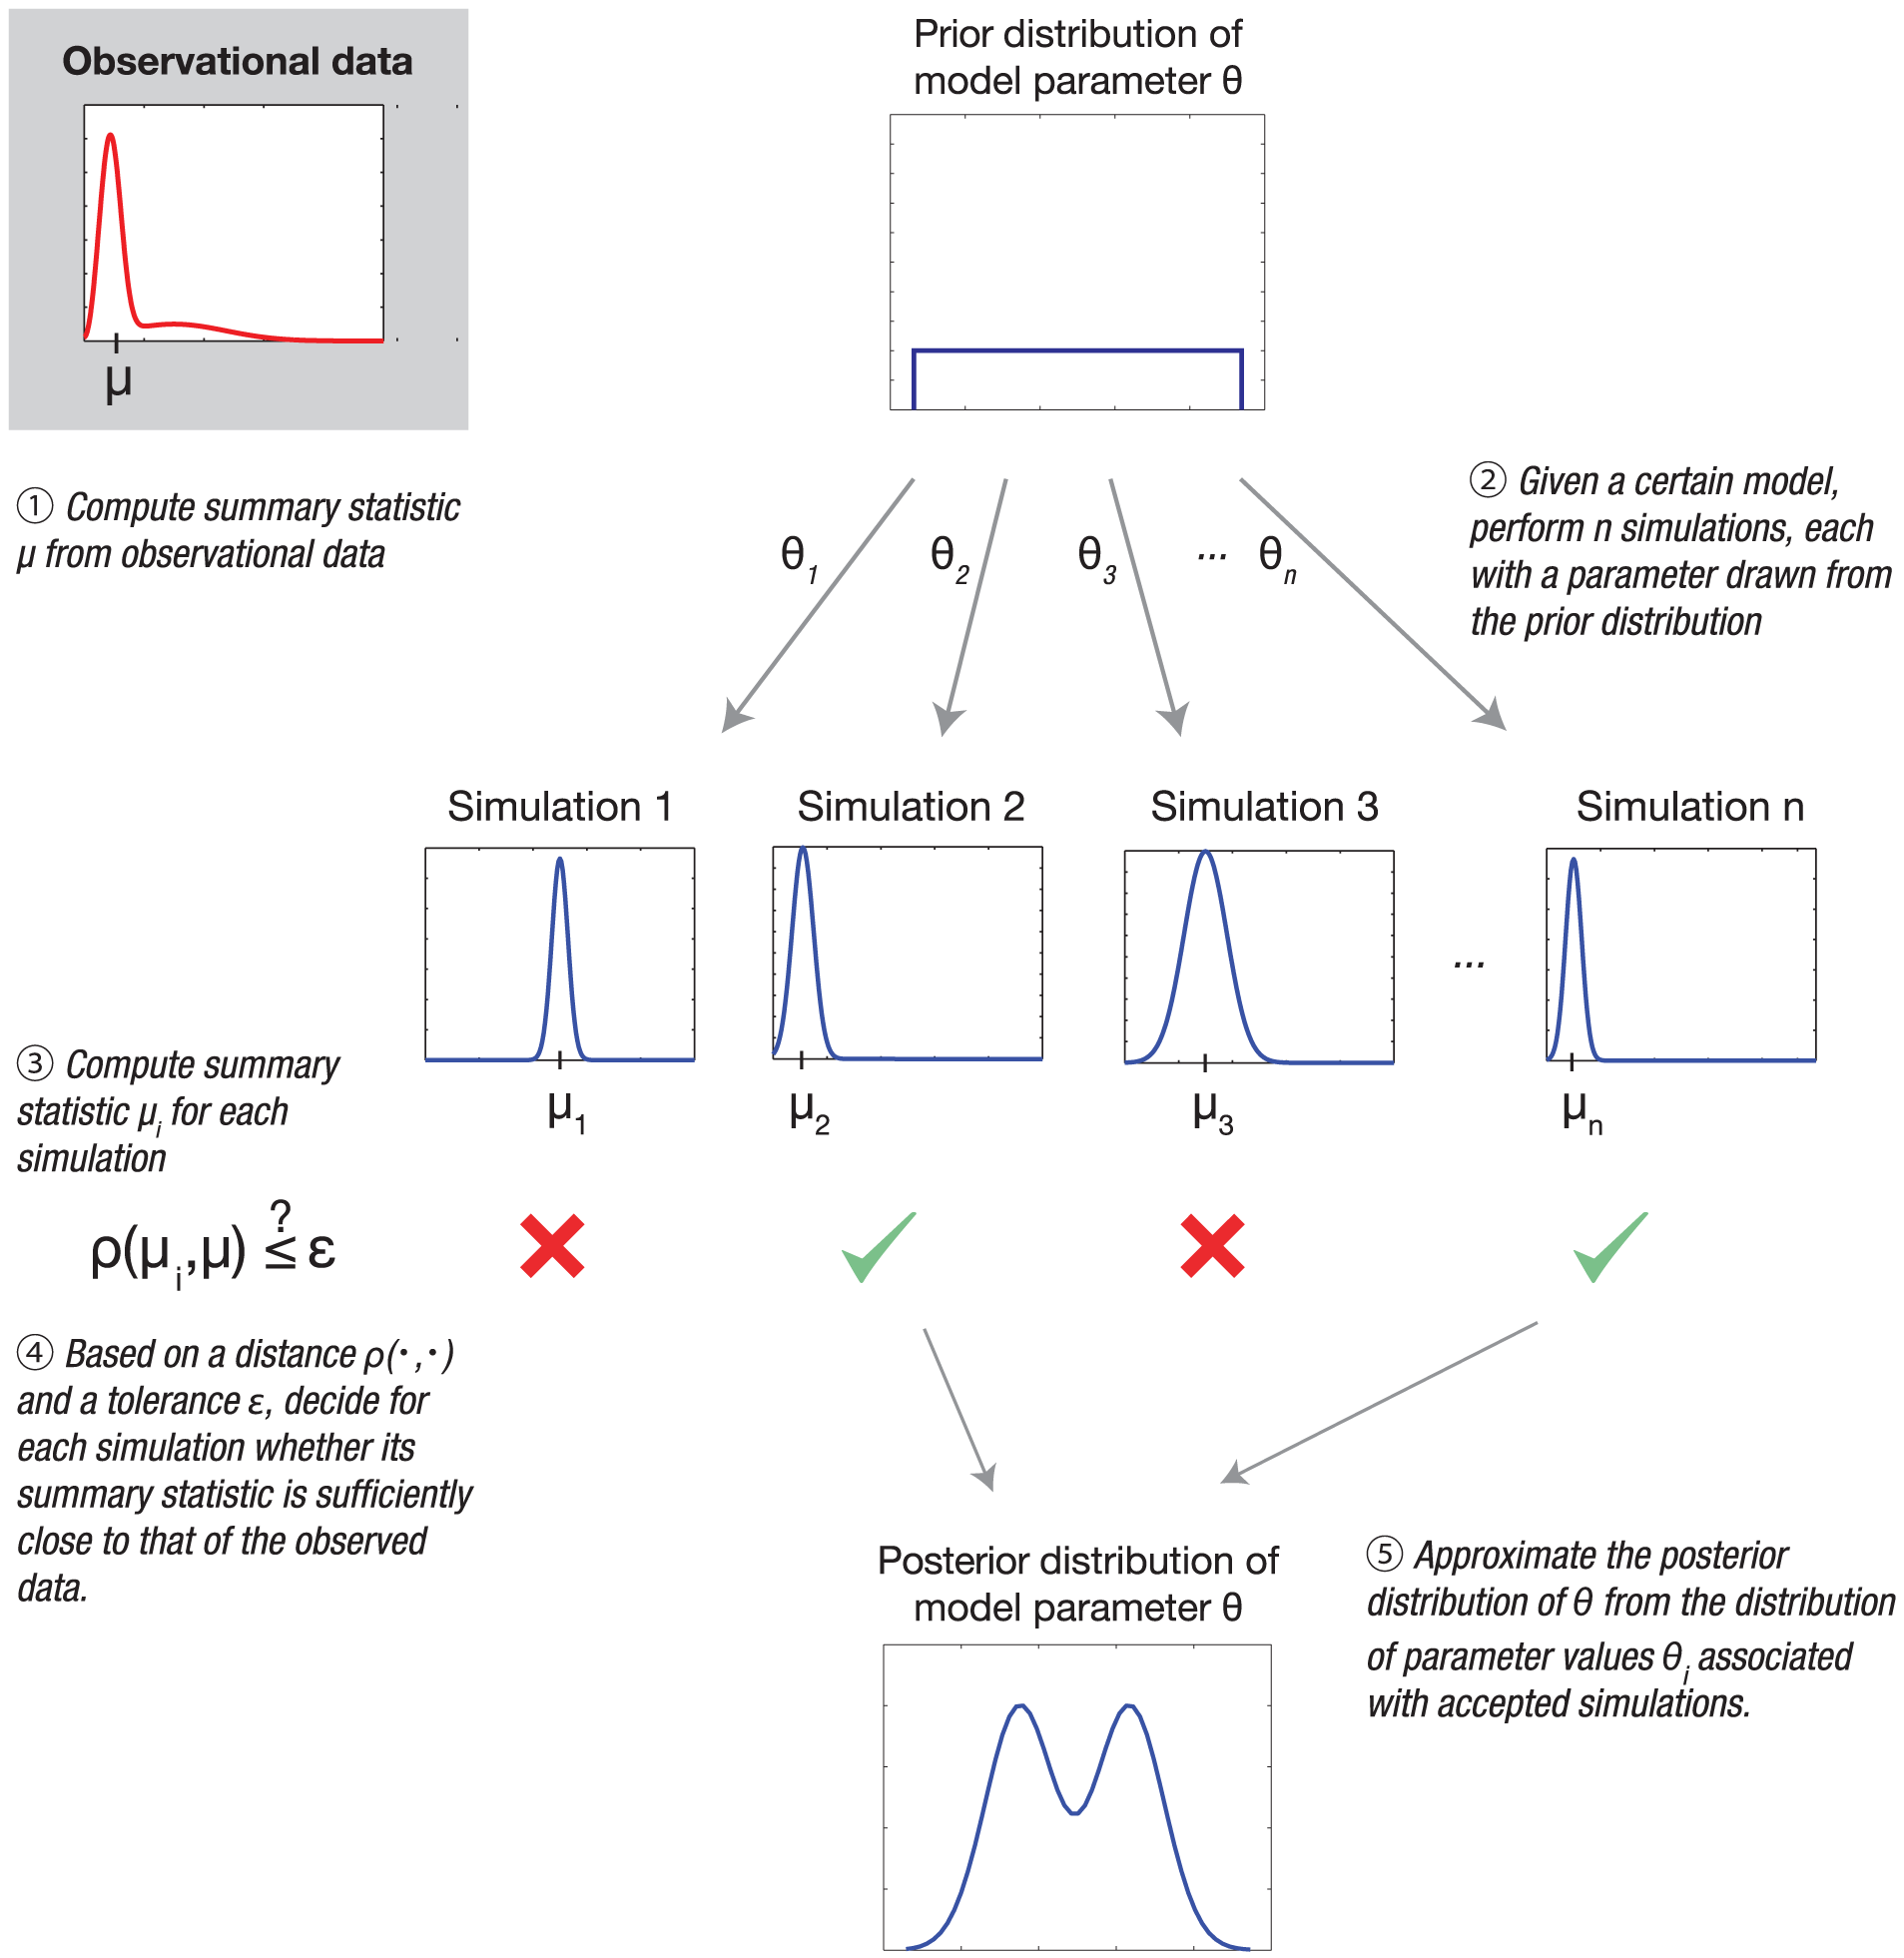

We will perform rejection ABC on the same model to obtain posterior over the parameters. To do so we need the following:

| Property | Description | Our choice |
| --- | --- | --- |
| A summary statistic | Used to gauge the quality of the generated data in comparison with observed data. | Frequency of state switches. |
| A distance function | Quantifies the difference between generated data and observed data in the summary statistic. | Absolute difference of switch frequency. |
| Tolerence | The threshold of acceptance; i.e. we will accept a sample if distance in summary statistic is within this range. | 10% |
| Number of parameter samples | The number of draws that we'll take from prior parameter values to determine the posterior. | 5,000

We'll define the rejection ABC version of the model with these choices:

In [523]:
class BistableHMMRejectionABC(object):

    def __init__(self, observations, tolerance, num_parameter_samples):
        super().__init__()
        
        self.obs_switch_freq = observations[1:].ne(observations[:-1]).float().mean()
        
        self.tolerance = tolerance
        self.num_parameter_samples = num_parameter_samples
        
        # Generate num_parameter_samples samples each of theta and gamma from their prior
        self.samples_theta = theta_prior.expand([self.num_parameter_samples]).sample()
        self.samples_gamma = gamma_prior.expand([self.num_parameter_samples]).sample()

        # Tensorized data generator model
        self.generated_data = torch.zeros([self.num_parameter_samples, N])
        self.internal_states = torch.zeros([self.num_parameter_samples, N])

    def _S(self, i):
        if i == 0:
            # Start with default state 0.
            return torch.zeros(self.num_parameter_samples)
        else:
            # Current state opposite from previous with p=theta and same as previous with p=1-theta.
            return dist.Bernoulli(
                self.samples_theta * (torch.ones(self.num_parameter_samples) - self.internal_states[:, i-1]) +
                (torch.ones(self.num_parameter_samples) - self.samples_theta) * self.internal_states[:, i-1]
            ).sample()


    def _M(self, i):
        # Measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
        return dist.Bernoulli(
            self.samples_gamma * self.internal_states[:, i] +
            (torch.ones(self.num_parameter_samples) - self.samples_gamma) * (1. - self.internal_states[:, i])
        ).sample()
    
    def infer(self):
        for i in range(N):
            self.internal_states[:, i] = self._S(i)
            self.generated_data[:, i] = self._M(i)
        
        differences = self.internal_states[:, 1:].ne(
            self.internal_states[:, :-1],
        ).float().mean(dim=1).sub(self.obs_switch_freq).abs()
        return {
            "accepted_thetas": self.samples_theta[ differences < self.tolerance ],
            "accepted_gammas": self.samples_gamma[ differences < self.tolerance ],
        }

We're now ready to run rejection ABC! All we need to do is provide the observed dataset and configurable parameters.

In [524]:
%%time

samples_abc = BistableHMMRejectionABC(true_M, tolerance=0.1, num_parameter_samples=5000).infer()
accepted_thetas = samples_abc["accepted_thetas"]
accepted_gammas = samples_abc["accepted_gammas"]
accepted_samples = torch.stack([accepted_thetas, accepted_gammas])

CPU times: user 50.4 ms, sys: 6.01 ms, total: 56.4 ms
Wall time: 72.6 ms


Let's take a look at the results. We'll compute statstics and visualize the posterior:

In [559]:
print(
    f"Samples accepted: {accepted_samples.shape[0]/5000. * 100 :.2f}% "
    f"({accepted_samples.shape[0]} / {5000})"
)

pd.DataFrame(
    np.stack([
        accepted_samples.mean(dim=1),
        accepted_samples.std(dim=1),
        *np.quantile(accepted_samples, [0.025, 0.5, 0.975], axis=1),
        bm.diagnostics.common_statistics.effective_sample_size(accepted_samples.T[None, :]),
    ]).T,
    columns=["avg", "std", "2.5%", "50%", "97.5%", "n_eff"],
    index=[r"$\hat\theta$", r"$\hat\gamma$"],
)

,avg,std,2.5%,50%,97.5%,n_eff
$\hat\theta$,0.319,0.073,0.185,0.318,0.461,953.687
$\hat\gamma$,0.866,0.126,0.558,0.903,0.999,919.813


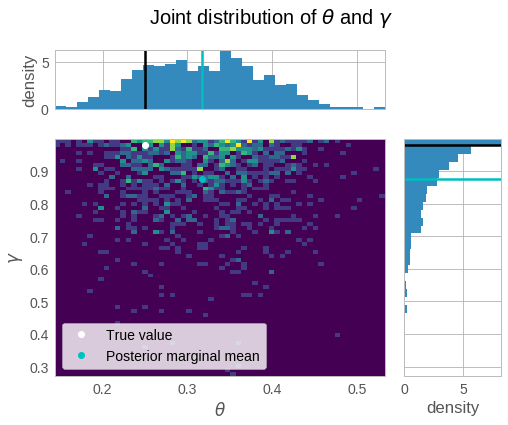

In [449]:
plot_marginal(
    r"$\theta$",
    accepted_thetas,
    true_theta,
    r"$\gamma$",
    accepted_gammas,
    true_gamma,
)

Compared to the fully-Bayesian approach, ABC seems to provide much wider confidence intervals, and somewhat worse point estimates. However, it computed in a fraction of a second, whereas the fully-Bayesian approach took an hour! This can be a compelling factor when you're looking to interactively iterate on your model, or reduce resources used.